## FINAL MODEL

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, LSTM
import seaborn as sns
from tcn import TCN
# Uncomment the next line if you install keras-tcn:


In [ ]:
from pmdarima import auto_arima

In [ ]:
# Uninstall conflicting and related packages
!pip uninstall numpy pmdarima tensorflow pandas scikit-learn tf-keras tensorflow-text tensorflow-hub dopamine-rl keras-hub -y

# Install compatible versions
!pip install numpy==1.26.4 pmdarima==2.0.4 tensorflow==2.18.0 pandas==2.2.2 scikit-learn==1.6.1 tf-keras==2.18.0 tensorflow-text==2.18.0

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
Found existing installation: dopamine_rl 4.1.2
Uninstalling dopamine_rl-4.1.2:
  Successfully uninstalled dopamine_rl-4.1.2
Found existing installation: keras-hub 0.18.1
Uninstalling keras-hub-0.18.1:
  Successfully uninstalled keras-hub-0.18.1
  Using cached numpy-1.26.4-cp311-c

In [ ]:
!pip install keras-tcn

In [ ]:
# Load dataset
file_path = "/content/Alandur iso.csv"
df = pd.read_csv(file_path)

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
pollutant_columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3']  # Adjust based on actual column names
df = df[pollutant_columns + ['AQI']].dropna()

In [ ]:
# Selecting only pollutants as features
features = df.drop(columns=['AQI'])
target = df['AQI']

# Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Define N-BEATS model
def build_nbeats_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

nbeats = build_nbeats_model(X_train.shape[1])
nbeats.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 35.7103 - val_loss: 27.2146
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.1540 - val_loss: 8.8842
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9787 - val_loss: 8.3283
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4850 - val_loss: 8.1966
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5136 - val_loss: 8.1014
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2493 - val_loss: 7.9913
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5666 - val_loss: 7.8547
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5631 - val_loss: 7.7006
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2602 - val_loss: 7.6750
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2057 - val_loss: 7.3891
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8416 - val_loss: 7.2530
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5835 - va

In [ ]:
# Gaussian Process Regression (GPR)
kernel = C(1.0) * RBF()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Hyperparameter tuning for GPR
param_grid = {'alpha': np.logspace(-3, 1, 10)}
gpr_search = RandomizedSearchCV(gpr, param_grid, n_iter=5, cv=3, random_state=42)
gpr_search.fit(X_train, y_train)
best_gpr = gpr_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: C

In [ ]:
# Make predictions
nbeats_pred = nbeats.predict(X_test).flatten()
gpr_pred = best_gpr.predict(X_test)

# Compute weighted ensemble
nbeats_r2 = r2_score(y_test, nbeats_pred)
gpr_r2 = r2_score(y_test, gpr_pred)
total_r2 = nbeats_r2 + gpr_r2
w1 = nbeats_r2 / total_r2
w2 = gpr_r2 / total_r2
ensemble_pred = (w1 * nbeats_pred) + (w2 * gpr_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
# --- Data Preparation for Sequence Models (LSTM and TCN) ---
sequence_length = 30  # Using past 30 days to predict the next day
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, -1])  # AQI is the last column
    return np.array(X), np.array(y)

# Prepare sequential data
data = df.values  # Full dataset with pollutants and AQI
X_seq, y_seq = create_sequences(data, sequence_length)
X_train_seq, X_temp_seq, y_train_seq, y_temp_seq = train_test_split(X_seq, y_seq, test_size=0.4, random_state=42)
X_val_seq, X_test_seq, y_val_seq, y_test_seq = train_test_split(X_temp_seq, y_temp_seq, test_size=0.5, random_state=42)

# --- TCN Model ---
tcn_model = Sequential([
     TCN(input_shape=(sequence_length, X_train_seq.shape[2])),
     Dense(1)
 ])
tcn_model.compile(optimizer='adam', loss='mae')
tcn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=16, verbose=1)
tcn_pred = tcn_model.predict(X_test_seq).flatten()

# --- LSTM Model ---
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X_train_seq.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=16, verbose=1)
lstm_pred = lstm_model.predict(X_test_seq).flatten()

# --- SARIMA Model ---
# Using only AQI for univariate time series models, set frequency
df_aqi = df['AQI'].asfreq('D')  # Assuming daily data
train_size = int(len(df_aqi) * 0.6)
val_size = int(len(df_aqi) * 0.2)
test_size = len(df_aqi) - train_size - val_size
train_aqi, val_aqi, test_aqi = df_aqi[:train_size], df_aqi[train_size:train_size+val_size], df_aqi[train_size+val_size:]

sarima_model = auto_arima(train_aqi, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
sarima_fit = sarima_model.fit(train_aqi)
sarima_pred = sarima_fit.predict(n_periods=len(test_aqi))

# --- ARIMA Model ---
arima_model = auto_arima(train_aqi, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
arima_fit = arima_model.fit(train_aqi)
arima_pred = arima_fit.predict(n_periods=len(test_aqi))

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:273: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 73.9876 - val_loss: 4.7481
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.2631 - val_loss: 4.1679
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.8278 - val_loss: 5.9286
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.1833 - val_loss: 4.8395
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 4.4472 - val_loss: 4.1222
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.1348 - val_loss: 3.7523
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.5577 - val_loss: 5.8892
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.3815 - val_loss: 4.8437
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.1836 - val_loss: 3.3103
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.3825 - val_loss: 3.4569
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.1106 - val_loss: 3.4997
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 177.5983 - val_loss: 180.3818
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 102.5592 - val_loss: 34.1059
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 34.5133 - val_loss: 29.1671
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 25.1469 - val_loss: 10.1164
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.7334 - val_loss: 9.2607
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.0892 - val_loss: 7.0007
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7238 - val_loss: 5.6373
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3623 - val_loss: 7.4502
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6644 - val_loss: 5.8543
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.0968 - val_loss: 6.0034
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.1765 - val_loss: 17.9511
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2919.436, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2748.556, Time=1.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2799.302, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4475.576, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=2750.735, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=2750.353, Time=2.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=2751.038, Time=0.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=2748.332, Time=0.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=2749.894, Time=1.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=2752.246, Time=2.49 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=2889.676, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=2719.869, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=2719.934, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,2)[7] intercept   : AIC=2720.522, Time=3.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=2720.064, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=2722.787, Time=2.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=2701.632, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=2700.705, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=2701.767, Time=1.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[7] intercept   : AIC=2701.340, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[7] intercept   : AIC=2700.410, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[7] intercept   : AIC=2700.862, Time=4.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[7] intercept   : AIC=2700.132, Time=1.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,2)[7] intercept   : AIC=2700.305, Time=1.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=3.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=2709.497, Time=1.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,1)[7] intercept   : AIC=2702.104, Time=3.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[7] intercept   : AIC=2702.100, Time=1.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=2707.283, Time=1.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,1)[7] intercept   : AIC=2701.048, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,1)[7] intercept   : AIC=2704.087, Time=1.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[7]             : AIC=2722.076, Time=0.82 sec

Best model:  ARIMA(3,0,1)(0,0,1)[7] intercept
Total fit time: 50.645 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2725.316, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4475.576, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2855.996, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3971.523, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2728.603, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2728.256, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2727.057, Time=0.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2727.213, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2727.685, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2730.359, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2720.599, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2708.730, Time=2.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=2707.509, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=1.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=2703.550, Time=1.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=2701.448, Time=0.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2700.410, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2707.868, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2700.705, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2701.475, Time=0.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2719.934, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2705.283, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2701.340, Time=0.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2703.472, Time=0.58 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 15.402 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Evaluate performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mape, rmse, r2

In [ ]:
# Metrics for each model
ensemble_metrics = evaluate_model(y_test, ensemble_pred)
lstm_metrics = evaluate_model(y_test_seq, lstm_pred)
sarima_metrics = evaluate_model(test_aqi, sarima_pred)
arima_metrics = evaluate_model(test_aqi, arima_pred)
tcn_metrics = evaluate_model(y_test_seq, tcn_pred)  # Placeholder if TCN not used

<ipython-input-40-d0edb24ed34d>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=df_metrics, palette='Blues')
<ipython-input-40-d0edb24ed34d>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAPE', data=df_metrics, palette='Greens')
<ipython-input-40-d0edb24ed34d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=df_metrics, palette='Oranges')
<ipython-input-40-d0edb24ed34d>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0

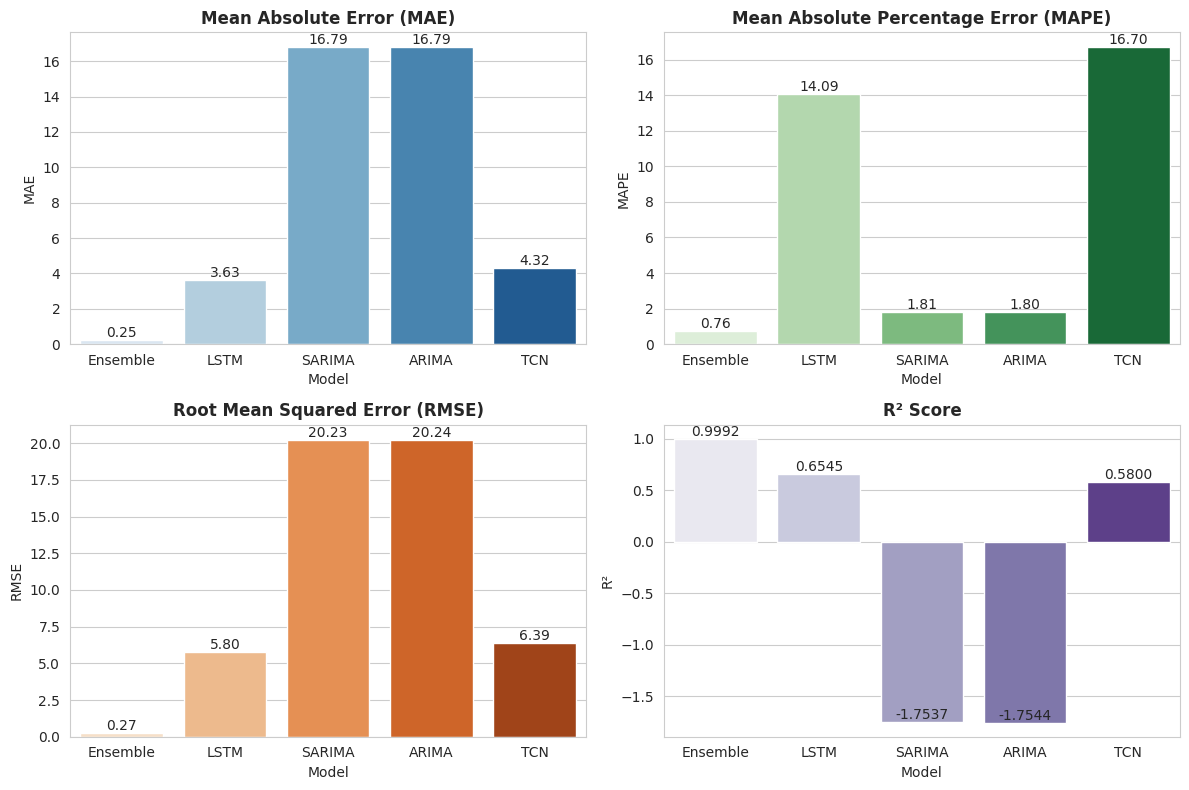

In [ ]:
# --- Visualization ---
models = ['Ensemble', 'LSTM', 'SARIMA', 'ARIMA', 'TCN']
metrics = ['MAE', 'MAPE', 'RMSE', 'R²']
data = {
    'Model': models,
    'MAE': [ensemble_metrics[0], lstm_metrics[0], sarima_metrics[0], arima_metrics[0], tcn_metrics[0]],
    'MAPE': [ensemble_metrics[1], lstm_metrics[1], sarima_metrics[1], arima_metrics[1], tcn_metrics[1]],
    'RMSE': [ensemble_metrics[2], lstm_metrics[2], sarima_metrics[2], arima_metrics[2], tcn_metrics[2]],
    'R²': [ensemble_metrics[3], lstm_metrics[3], sarima_metrics[3], arima_metrics[3], tcn_metrics[3]]
}
df_metrics = pd.DataFrame(data)

# Create a 2x2 grid of bar plots
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# MAE Plot
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='MAE', data=df_metrics, palette='Blues')
plt.title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
for i, v in enumerate(df_metrics['MAE']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# MAPE Plot
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='MAPE', data=df_metrics, palette='Greens')
plt.title('Mean Absolute Percentage Error (MAPE)', fontsize=12, fontweight='bold')
for i, v in enumerate(df_metrics['MAPE']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# RMSE Plot
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='RMSE', data=df_metrics, palette='Oranges')
plt.title('Root Mean Squared Error (RMSE)', fontsize=12, fontweight='bold')
for i, v in enumerate(df_metrics['RMSE']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# R² Plot
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='R²', data=df_metrics, palette='Purples')
plt.title('R² Score', fontsize=12, fontweight='bold')
for i, v in enumerate(df_metrics['R²']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

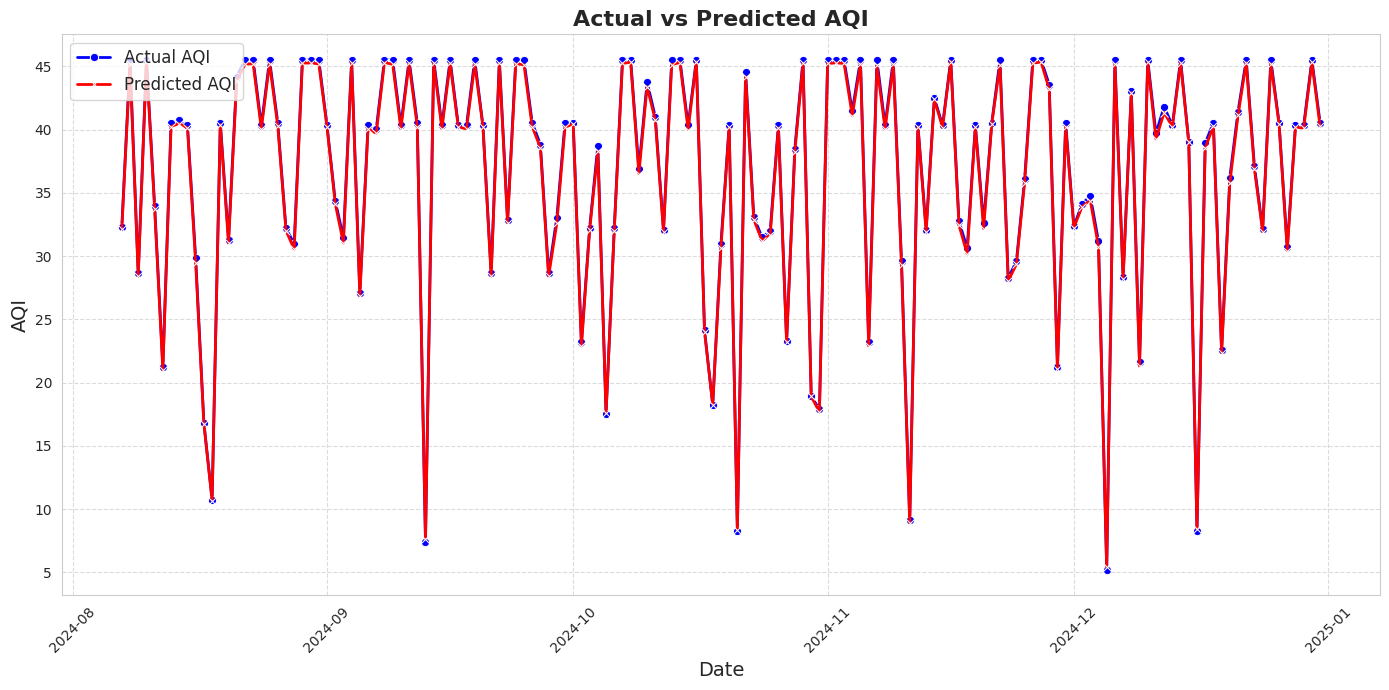

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the dates corresponding to the test set
test_dates = df.index[-len(y_test):]  # Assumes df index is datetime and test set is the last portion

# Create the visualization
plt.figure(figsize=(14, 7))  # Wide figure for better readability
sns.lineplot(x=test_dates, y=y_test, label='Actual AQI', color='blue', marker='o', linewidth=2)
sns.lineplot(x=test_dates, y=ensemble_pred, label='Predicted AQI', color='red', marker='x', linewidth=2)

# Customize the plot for attractiveness
plt.title('Actual vs Predicted AQI', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('AQI', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)  # Light grid for readability
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# Evaluate individual models
nbeats_mae, nbeats_mape, nbeats_rmse, nbeats_r2 = evaluate_model(y_test, nbeats_pred)
gpr_mae, gpr_mape, gpr_rmse, gpr_r2 = evaluate_model(y_test, gpr_pred)
ensemble_mae, ensemble_mape, ensemble_rmse, ensemble_r2 = evaluate_model(y_test, ensemble_pred)
lstm_mae, lstm_mape, lstm_rmse, lstm_r2 = evaluate_model(y_test_seq, lstm_pred)
sarima_mae, sarima_mape, sarima_rmse, sarima_r2 = evaluate_model(test_aqi, sarima_pred)
arima_mae, arima_mape, arima_rmse, arima_r2 = evaluate_model(test_aqi, arima_pred)
tcn_mae, tcn_mape, tcn_rmse, tcn_r2 = evaluate_model(y_test_seq, tcn_pred)

# Print metrics for all models
print("N-BEATS Model:")
print(f"MAE: {nbeats_mae}, MAPE: {nbeats_mape}%, RMSE: {nbeats_rmse}, R² Score: {nbeats_r2}")

print("\nGPR Model:")
print(f"MAE: {gpr_mae}, MAPE: {gpr_mape}%, RMSE: {gpr_rmse}, R² Score: {gpr_r2}")

print("\nEnsemble Model:")
print(f"MAE: {ensemble_mae}, MAPE: {ensemble_mape}%, RMSE: {ensemble_rmse}, R² Score: {ensemble_r2}")

print("\nLSTM Model:")
print(f"MAE: {lstm_mae}, MAPE: {lstm_mape}%, RMSE: {lstm_rmse}, R² Score: {lstm_r2}")

print("\nSARIMA Model:")
print(f"MAE: {sarima_mae}, MAPE: {sarima_mape}%, RMSE: {sarima_rmse}, R² Score: {sarima_r2}")

print("\nARIMA Model:")
print(f"MAE: {arima_mae}, MAPE: {arima_mape}%, RMSE: {arima_rmse}, R² Score: {arima_r2}")

print("\nTCN Model:")
print(f"MAE: {tcn_mae}, MAPE: {tcn_mape}%, RMSE: {tcn_rmse}, R² Score: {tcn_r2}")

N-BEATS Model:
MAE: 0.5054927683070588, MAPE: 1.4630326140254657%, RMSE: 0.5469622577226809, R² Score: 0.99670867271127

GPR Model:
MAE: 0.036577244285846085, MAPE: 0.24869720469159498%, RMSE: 0.07356362207698737, R² Score: 0.9999404636013532

Ensemble Model:
MAE: 0.2535377576827163, MAPE: 0.7551150488143205%, RMSE: 0.2731030109123001, R² Score: 0.9991794419171296

LSTM Model:
MAE: 3.6293826597966015, MAPE: 14.087437773472614%, RMSE: 5.799815653576131, R² Score: 0.6545190677250299

SARIMA Model:
MAE: 16.794864594813774, MAPE: 1.8069114324434983%, RMSE: 20.23414494928091, R² Score: -1.753704789843356

ARIMA Model:
MAE: 16.791835101976375, MAPE: 1.8012186779274242%, RMSE: 20.236742571385076, R² Score: -1.7544118662825379

TCN Model:
MAE: 4.3174565347696765, MAPE: 16.697091642694563%, RMSE: 6.3948318367308055, R² Score: 0.579995483916622


In [ ]:
# Forecast next 28 days
future_dates = pd.date_range(start=df.index[-1], periods=28, freq='D')
future_features = X_test.iloc[:28]
nbeats_future = nbeats.predict(future_features).flatten()
gpr_future = best_gpr.predict(future_features)
ensemble_future = (w1 * nbeats_future) + (w2 * gpr_future)

# Save results to CSV
forecast_df = pd.DataFrame({'Date': future_dates, 'AQI_Forecast': ensemble_future})
forecast_df.to_csv("AQI_forecast.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


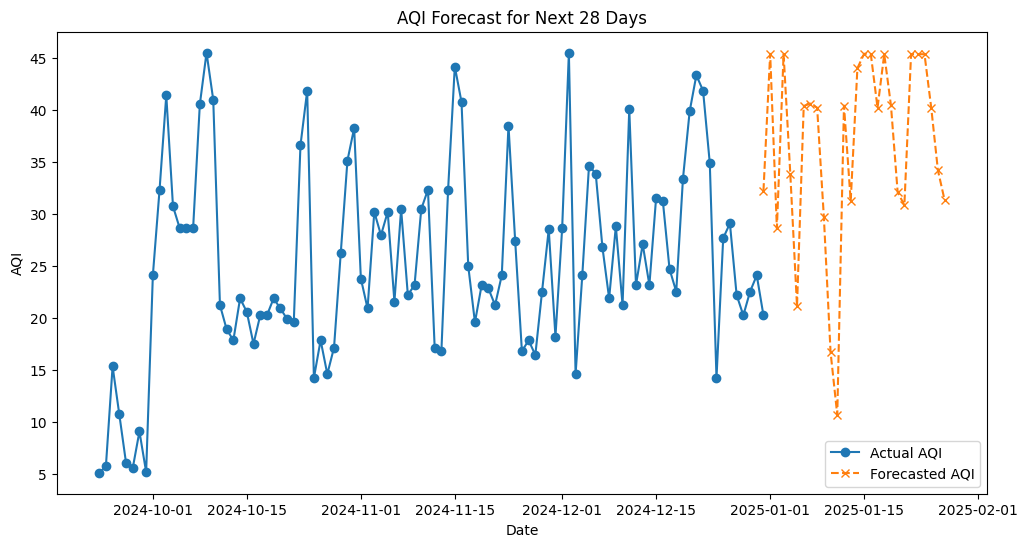

In [ ]:


# Visualization
plt.figure(figsize=(12,6))
plt.plot(df.index[-100:], df['AQI'].iloc[-100:], label='Actual AQI', marker='o')
plt.plot(future_dates, ensemble_future, label='Forecasted AQI', linestyle='dashed', marker='x')
plt.title('AQI Forecast for Next 28 Days')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()
